# Introduction
In this notebook we will test the implementation of the AlexNet class provided in the `alexnet.py` file. This is part of [this](https://kratzert.github.io/2017/02/24/finetuning-alexnet-with-tensorflow.html) blog article on how to finetune AlexNet with TensorFlow 1.0.

To run this notebook you have to download the `bvlc_alexnet.npy` file from [here](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/), which stores the pretrained weigts of AlexNet.

The idea to validate the implementation is to create an AlexNet graph with the provided script and load all pretrained weights into the variables (so no finetuneing!), to see if everything is wired up correctly.

In [1]:
#some basic imports and setups
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')

%matplotlib inline

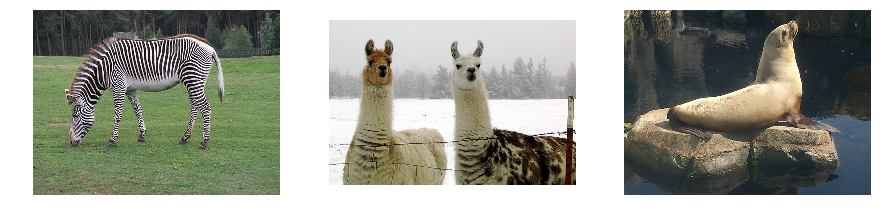

In [35]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpeg')]

#load all images
imgs = []
for f in img_files:
    img = cv2.imread(f)
#     img = cv2.resize(img, (227, 227))
    img = img.astype(np.float32)
#     print(img.dtype)
    img -= imagenet_mean
    imgs.append(img)
#     imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    img += imagenet_mean
    img = img.astype(np.uint8)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

First we will create placeholder for the dropout rate and the inputs and create an AlexNet object. Then we will link the activations from the last layer to the variable `score` and define an op to calculate the softmax values.

In [3]:
from alexnet import AlexNet
from caffe_classes import class_names

tf.reset_default_graph()

batch_size = 3
#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [batch_size, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = AlexNet(x, keep_prob, 1000, [])

#define activation of last layer as score
score = model.fc8

#create op to calculate softmax 
softmax = tf.nn.softmax(score)


Now we will start a TensorFlow session and load pretrained weights into the layer weights. Then we will loop over all images and calculate the class probability for each image and plot the image again, together with the predicted class and the corresponding class probability.

(375, 500, 3)
(227, 227, 3)
(336, 500, 3)
(227, 227, 3)
(375, 500, 3)
(227, 227, 3)


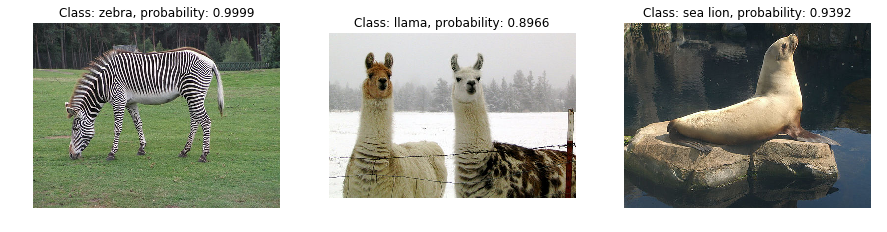

In [17]:
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Loop over all images
    for i, image in enumerate(imgs):
#         print(np.shape(image))
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))
#         print(np.shape(img))
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        # Plot image with class name and prob in the title
        fig2.add_subplot(1,3,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')

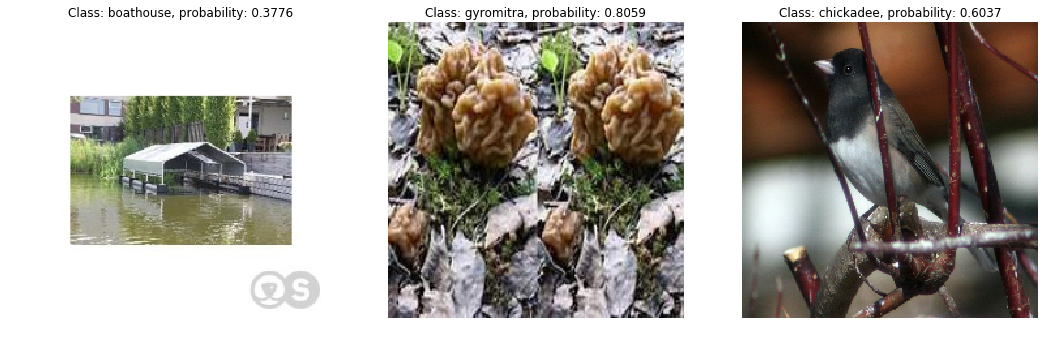

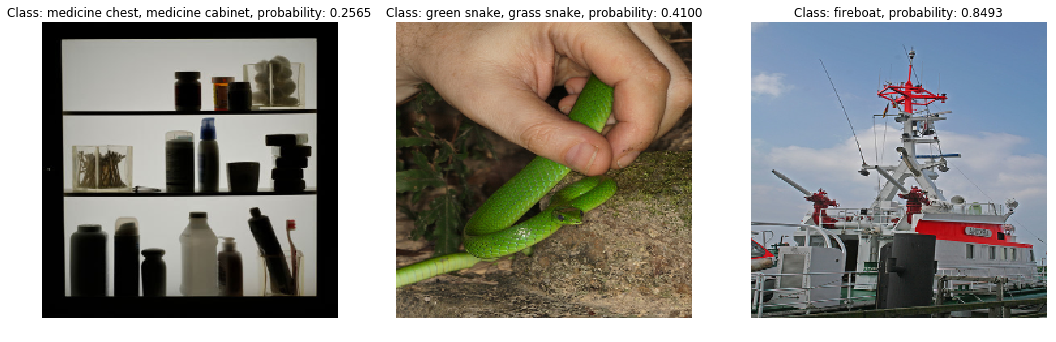

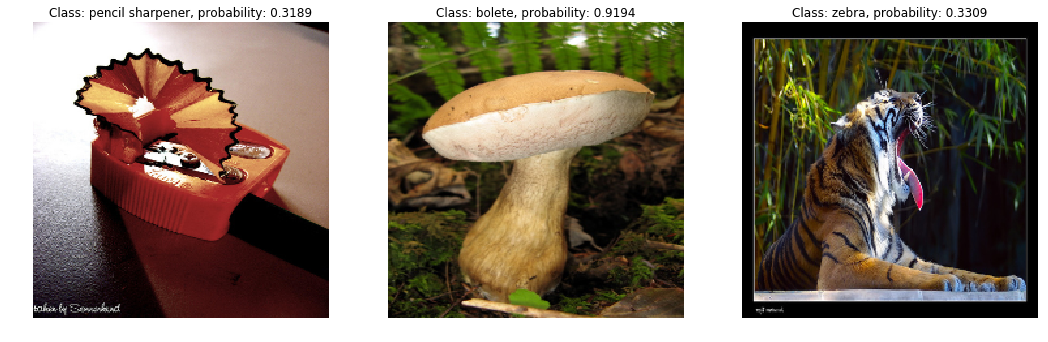

In [42]:
from datagenerator import ImageDataGenerator
# Test random images

# Test multiple batches of images
num_batches = 3

# Path to the textfiles for the trainings and validation set
train_file = './train.txt'
val_file = './val.txt'

train_generator = ImageDataGenerator(train_file, horizontal_flip = True, shuffle = True)
val_generator = ImageDataGenerator(val_file, shuffle = False)

with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handles
    fig_handles = []
    
    # Loop over all images
    for i in range(num_batches):
        fig_handles.append(plt.figure(figsize=(18,6)))
        batch_xs, batch_ys = train_generator.next_batch(batch_size)

        # Convert image to float32 and resize to (227x227)
        imgs = batch_xs.astype(np.float32)

        # Images from ImageDataGenerator already have mean subtracted
        
        # Run the session and calculate the class probability
        with tf.Graph().as_default():
            probs = sess.run(softmax, feed_dict={x: batch_xs, keep_prob: 1})

        # Get the class names of the classes with the highest probability
        class_names = np.array(class_names)
        batch_class_names = class_names[np.argmax(probs, 1)]

        # Plot images
        for img_ind, img in enumerate(batch_xs):

            # Plot images with class names and probs in the title
            ax = fig_handles[i].add_subplot(1,3,img_ind+1)
            img += imagenet_mean 
            img = img.astype(np.uint8)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.title.set_text("Class: " + batch_class_names[img_ind] + ", probability: %.4f" %probs[img_ind,np.argmax(probs, 1)[img_ind]])
            plt.axis('off')

In [40]:
from datagenerator import ImageDataGenerator

# Path to the textfiles for the trainings and validation set
train_file = './train.txt'
val_file = './val.txt'

# Test random images:
train_generator = ImageDataGenerator(train_file, horizontal_flip = False, shuffle = True)
val_generator = ImageDataGenerator(val_file, shuffle = False)

# Get the number of training/validation steps per epoch
train_batches_per_epoch = np.floor(train_generator.data_size / 128).astype(np.int32)
print(train_batches_per_epoch)

print("data_size: " + str(train_generator.data_size))

10009
data_size: 1281167


[[[  16.   15.   11.]
  [  13.   13.    9.]
  [  17.   13.   12.]
  ..., 
  [  20.   31.   14.]
  [  32.   31.   23.]
  [  22.   26.   15.]]

 [[  13.   14.    9.]
  [  13.    9.   10.]
  [  13.   13.   13.]
  ..., 
  [  27.   33.   16.]
  [  12.   18.    7.]
  [   6.    3.    4.]]

 [[  21.   19.   15.]
  [  16.   18.    8.]
  [  20.   17.   15.]
  ..., 
  [  21.   22.   17.]
  [  77.   95.   81.]
  [  63.  100.   84.]]

 ..., 
 [[ 142.  175.  205.]
  [ 140.  163.  185.]
  [  92.  112.  150.]
  ..., 
  [  99.   86.   82.]
  [  98.   94.   86.]
  [  92.   83.   73.]]

 [[  99.  138.  171.]
  [  69.  106.  146.]
  [  79.  100.  128.]
  ..., 
  [  97.   82.   90.]
  [ 144.  135.  132.]
  [  99.   83.   84.]]

 [[ 125.  150.  180.]
  [ 105.  119.  140.]
  [  94.  124.  166.]
  ..., 
  [  74.   69.   66.]
  [  81.   73.   79.]
  [ 105.   96.   96.]]]
float32
[[[ 125.   71.   20.]
  [ 122.   72.   26.]
  [ 123.   78.   20.]
  ..., 
  [  90.   45.   10.]
  [  86.   49.    3.]
  [  85.   44. 

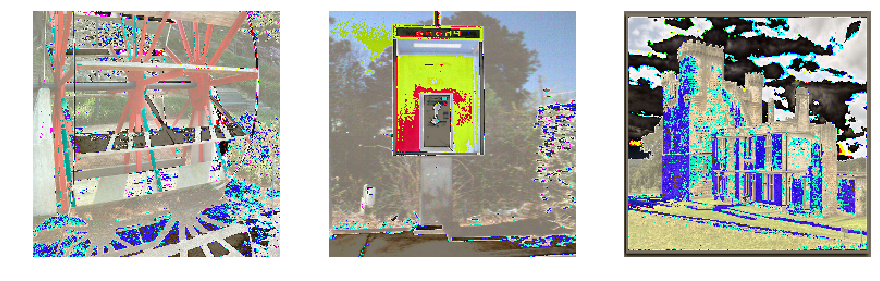

In [43]:
batch_xs, batch_ys = train_generator.next_batch(3)
batch_xs = batch_xs.astype(np.float32)
batch_xs += imagenet_mean
# print(np.shape(batch_xs))
# print(batch_xs.dtype)
# print(batch_xs[0])
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(batch_xs):
    fig.add_subplot(1,3,i+1)
    print(img)
    print(img.dtype)
    img = img.astype(np.uint8)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.imshow(img)
    plt.axis('off')